#  Práctica Obligatoria - Parte III - CNN

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">CNNs</p>***

En esta parte, entrenarás varias redes CNNs y analizarás sus resultados en el dataset GTS. 


### Evaluación - 4/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.25 puntos.
- **[Ejercicio 2]** 0.25 puntos.
- **[Ejercicio 3]** 0.5 puntos.
- **[Ejercicio 4]** 3 puntos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from gts_dataset import GTS


## Importa las funciones que has creado desde `utils.py`:

In [2]:
from utils import count_trainable_params, train, evaluate, train_and_evaluate, save_full_model, load_full_model, plot_loss_accuracy, plot_confusion_matrix, plot_error_per_class

## Carga el dataset GTS  y crea los dataloaders:

In [3]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

device = 'cpu'
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## **[Ejercicio 1]** Crea un modelo `CNN` con las siguientes características:

1. Tres bloques convolucionales (conv2d -> batch norm -> ReLU).
2. Flatten para aplanar características.
3. Una capa densa para clasificación.
4. Comprueba el número de parámetros entrenables y busca una configuración que no supere los **50.000** parámetros (aproximadamente 4 veces menos que la MLP).

In [4]:
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(16, 20, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(20)

        # Capa de aplanado
        self.flatten = nn.Flatten()

        # Linear para la clasificación
        self.fc = nn.Linear(20*7*7, output_dim)

    def forward(self, x):
        # Primer bloque convolucional
        x = F.relu(self.bn1(self.conv1(x)))

        # Segundo bloque convolucional
        x = F.relu(self.bn2(self.conv2(x)))

        # Tercer bloque convolucional
        x = F.relu(self.bn3(self.conv3(x)))

        # Aplanar la salida de la última capa convolucional
        x = self.flatten(x)

        # Linear para clasificación
        x = self.fc(x)

        return x

print(count_trainable_params(CNN(output_dim=43)))

47955


Guarda el modelo en `models.py`

### Entrena el modelo CNN con las funciones que has importado y analiza los resultados:

Epoch [1/10] - Train Loss: 0.7926, Val Acc: 0.9394
Epoch [2/10] - Train Loss: 0.1604, Val Acc: 0.9550
Epoch [3/10] - Train Loss: 0.0916, Val Acc: 0.9523
Epoch [4/10] - Train Loss: 0.0656, Val Acc: 0.9622
Epoch [5/10] - Train Loss: 0.0476, Val Acc: 0.9677
Epoch [6/10] - Train Loss: 0.0382, Val Acc: 0.9676
Epoch [7/10] - Train Loss: 0.0307, Val Acc: 0.9612
Epoch [8/10] - Train Loss: 0.0284, Val Acc: 0.9616
Epoch [9/10] - Train Loss: 0.0197, Val Acc: 0.9716
Epoch [10/10] - Train Loss: 0.0259, Val Acc: 0.9715


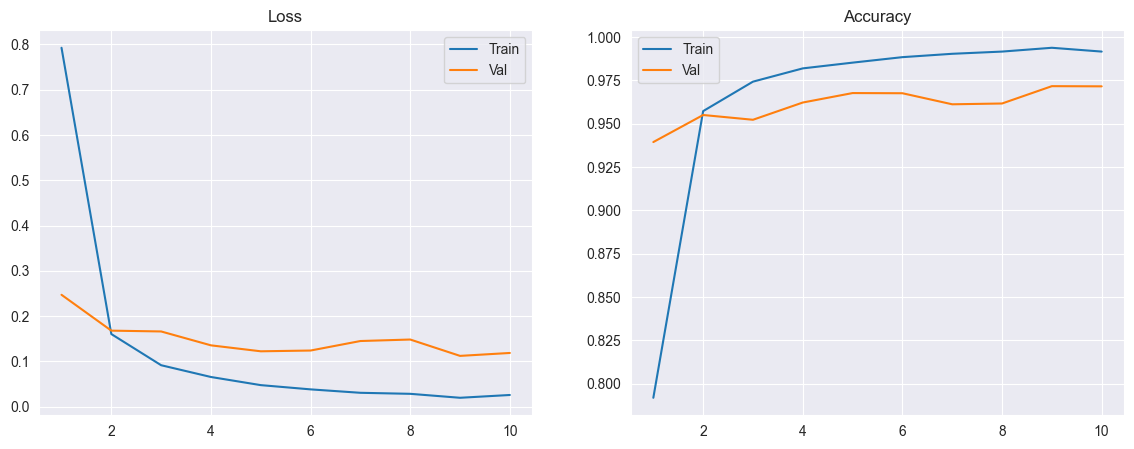

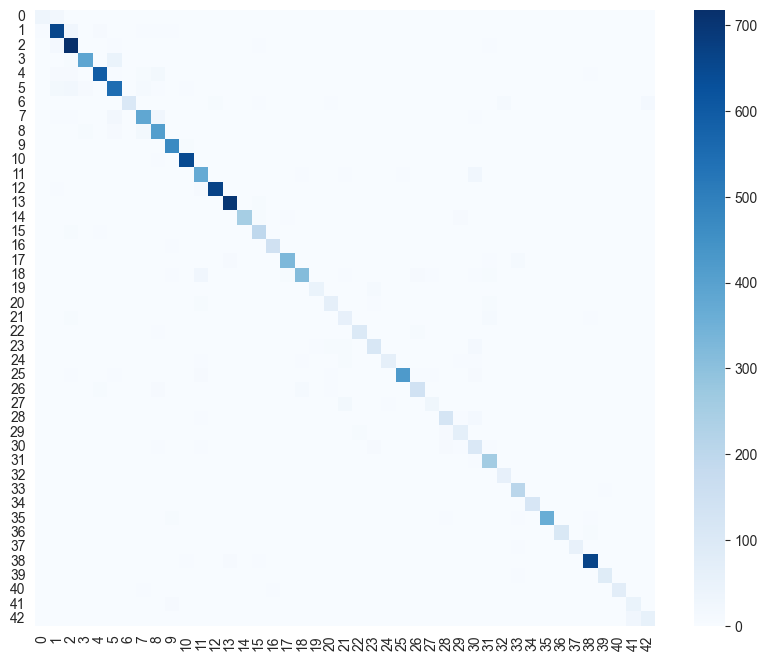

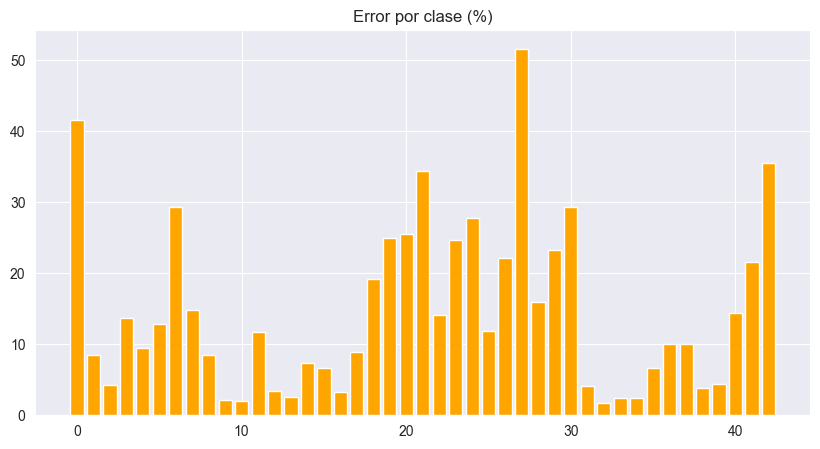

In [5]:
# Instancia el modelo
model_cnn = CNN(output_dim=43).to(device)

# Instancia la función de pérdida y el optimizador
loss_fn =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='cnn'
train_loss_df, val_loss_df, test_loss, test_accuracy = train_and_evaluate(
    model_cnn,
    train_loader,
    valid_loader,
    loss_fn,
    optimizer,
    device,
    num_epochs,
    test_loader,
    name='cnn'
)




# Guarda el modelo con file_name='cnn.pth'
save_full_model(model_cnn, 'cnn.pth')

# Carga los datos y muéstralos
train_loss_file = 'train_loss_cnn.csv'  
valid_loss_file = 'valid_loss_cnn.csv'
train_accuracy_file = 'train_accuracy_cnn.csv'
valid_accuracy_file = 'valid_accuracy_cnn.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# Calcula la matriz de confusión
cm = plot_confusion_matrix(model_cnn, test_loader, device=device)

# Muestra el porcentaje de error por clase
plot_error_per_class(cm)

Describe las diferencias en los resultados que has obtenido.

############## COMPLETAR ##############

- La MLP que usábamos anteriormente usaba aproximadamente unos 200000 parámetros para alcanzar una precisioón del 88% aprox. ahora con una CNN con unos 48000 parámetros, logramos un accuracy del 96% aprox. lo que nos demuestra que las CNN son mucho más adecuadas para procesari imagenes que las MLP

- En cuanto al error por clase, la MLP mostraba un error muy elevado distribuido en bastantes clases, ahora con la CNN aunque todavía tiene dificultades con algunas señales específicas, el error general del resto de las clases a disminuido notablemente.

- La diagonal de la matriz de confusión de la CNN es mucho más limpia y definida, mientras que la MLP confundía señales.

############ Fin COMPLETAR ############

## **[Ejercicio 2]** Dataset permutado: re-entrena la MLP y la CNN

Esta vez, vuelve a entrenar la `MLP`y la `CNN` que has configurado pero con el mismo dataset modificado.

Esta modificación consiste en permutar los píxeles de las imágenes siempre de la misma manera.


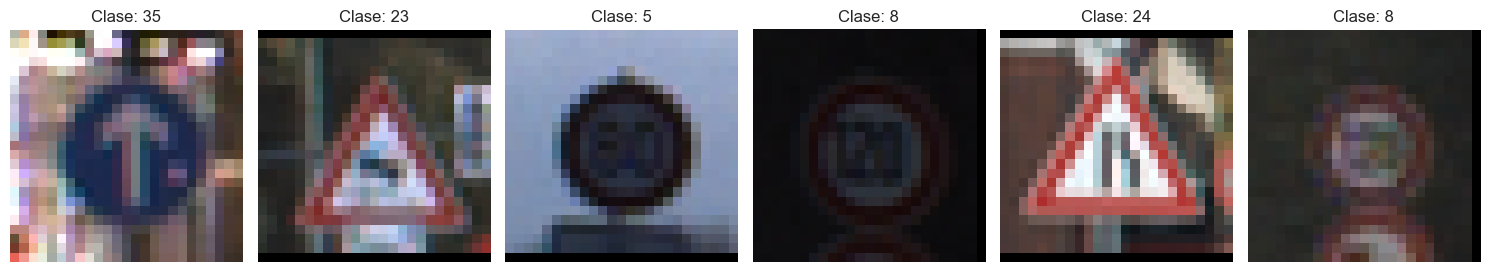

In [5]:
def visualize_subset(dataset, num_images=6):
    """
    Visualiza ejemplos directamente de un Subset o Dataset.
    
    :param dataset: Dataset o Subset que contiene las imágenes y etiquetas.
    :param num_images: Número de imágenes a mostrar.
    """
    indices = np.arange(num_images)
    images = []
    labels = []
    
    for idx in indices:
        image, label = dataset[idx]
        images.append(image)
        labels.append(label)
    
    images = torch.stack(images)  # Convertir la lista de imágenes en un tensor
    images = images.permute(0, 2, 3, 1).numpy()  


    # Mostrar imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx in range(num_images):
        axes[idx].imshow(images[idx])
        axes[idx].set_title(f"Clase: {labels[idx]}")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()


# Visualizar ejemplos del conjunto de entrenamiento
visualize_subset(train_dataset)

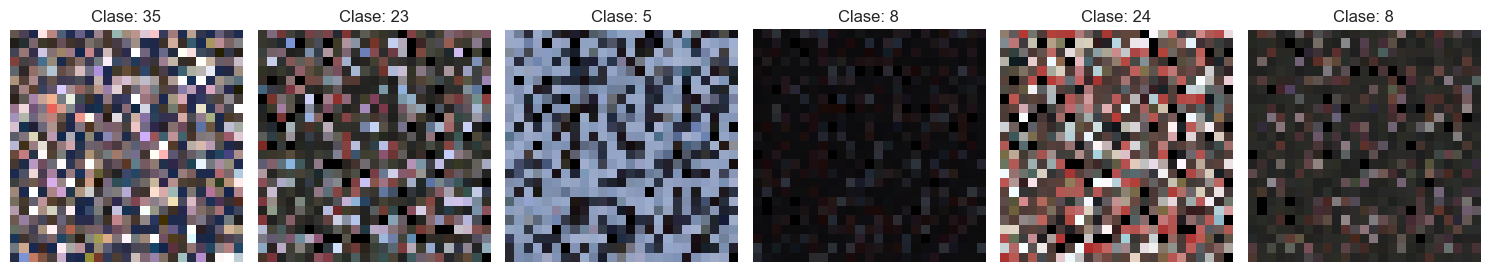

In [6]:
class ShufflePixels:
    def __init__(self, seed=42):
        """
        Inicializa la transformación de shuffle de píxeles.
        Args:
            seed (int): Semilla para generar una permutación fija.
        """
        self.seed = seed
        torch.manual_seed(self.seed)  # Fijar la semilla
        self.permutation = None

    def __call__(self, img):
        """
        Aplica la permutación a los píxeles de la imagen.
        Args:
            img (torch.Tensor): Imagen en formato (C, H, W).
        Returns:
            torch.Tensor: Imagen con píxeles permutados.
        """
        C, H, W = img.shape  # Extraer dimensiones de la imagen

        if self.permutation is None:
            # Generar permutación fija
            self.permutation = torch.randperm(H * W)  # Permutación fija en 1D

        # Aplanar la imagen, permutar y restaurar forma original
        img = img.view(C, H * W)  # (C, H * W)
        img = img[:, self.permutation]  # Aplicar la permutación
        img = img.view(C, H, W)  # Restaurar la forma original
        return img

# Definir las transformaciones con shuffle de píxeles
transform = transforms.Compose([
    transforms.ToTensor(),
    ShufflePixels(seed=42)  # Aplicar shuffle fijo
])
train_dataset_shuffle = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset_shuffle = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset_shuffle = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

device = 'cpu'
batch_size = 16

train_loader_shuffle = DataLoader(train_dataset_shuffle, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader_shuffle = DataLoader(valid_dataset_shuffle, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_shuffle = DataLoader(test_dataset_shuffle, batch_size=batch_size, shuffle=False, num_workers=0)


# Visualizar ejemplos del conjunto de entrenamiento
visualize_subset(train_dataset_shuffle)

### Entrena la MLP con:

* `train_loader_shuffle`
* `valid_loader_shuffle`
* `test_loader_shuffle`

Guarda el modelo como `mlp_shuffle.pth` y los resultados de `loss` y `accuracy`con la misma extensión:

Epoch [1/10] - Train Loss: 2.3236, Val Acc: 0.5943
Epoch [2/10] - Train Loss: 1.2523, Val Acc: 0.7354
Epoch [3/10] - Train Loss: 0.8916, Val Acc: 0.7989
Epoch [4/10] - Train Loss: 0.7088, Val Acc: 0.8385
Epoch [5/10] - Train Loss: 0.5979, Val Acc: 0.8545
Epoch [6/10] - Train Loss: 0.5306, Val Acc: 0.8538
Epoch [7/10] - Train Loss: 0.4784, Val Acc: 0.8762
Epoch [8/10] - Train Loss: 0.4519, Val Acc: 0.8569
Epoch [9/10] - Train Loss: 0.4093, Val Acc: 0.8923
Epoch [10/10] - Train Loss: 0.3863, Val Acc: 0.8832


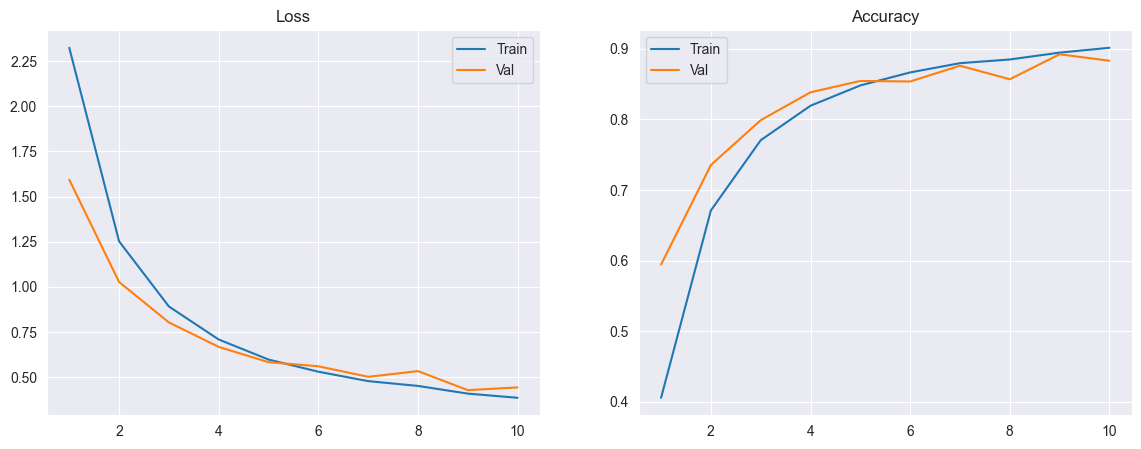

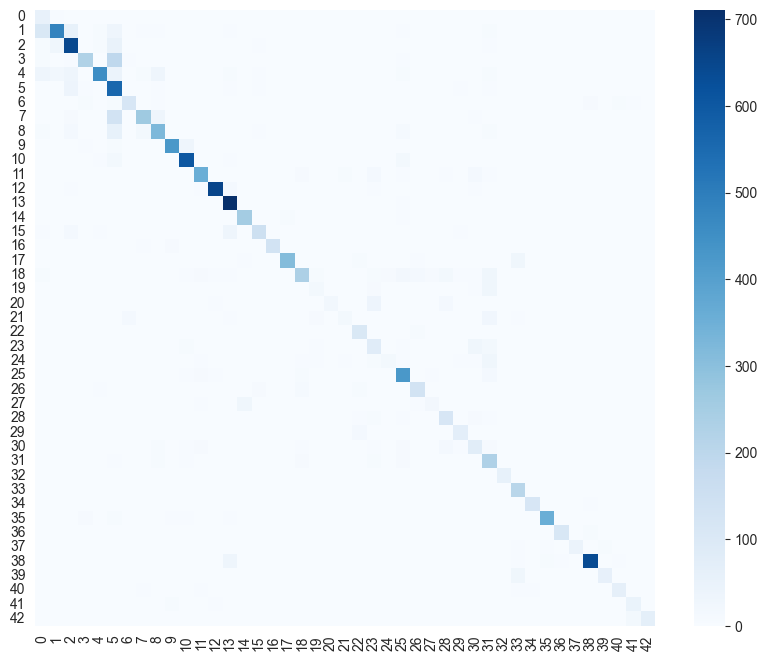

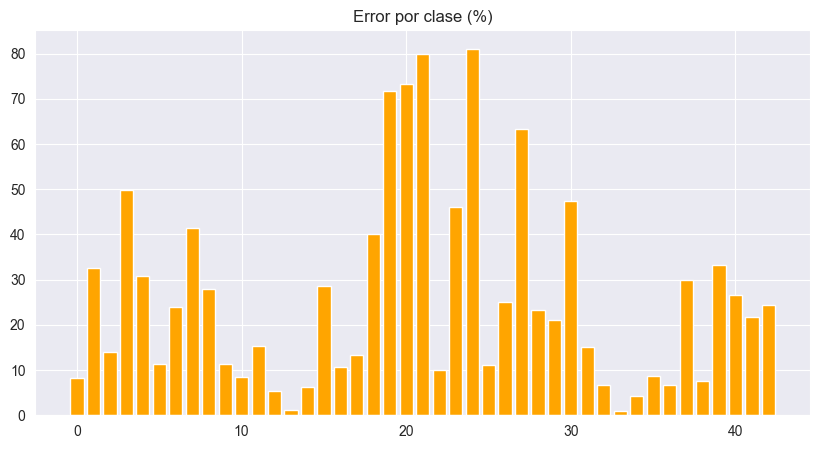

In [8]:
from models import MLP

# Instancia el modelo
model_mlp = MLP(input_size=25*25*3, hidden_size=100, output_size=43).to(device)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='mlp_shuffle'
train_loss_df, val_loss_df, test_loss, test_accuracy = train_and_evaluate(
    model_mlp, train_loader_shuffle, valid_loader_shuffle,
    loss_fn, optimizer, device, num_epochs=10,
    test_loader=test_loader_shuffle, name='mlp_shuffle'
)




# Guarda el modelo. Usa file_name='mlp_shuffle.pth'
save_full_model(model_mlp, 'mlp_shuffle.pth')

# Carga los datos y muéstralos
train_loss_file = 'train_loss_mlp_shuffle.csv'  
valid_loss_file = 'valid_loss_mlp_shuffle.csv'
train_accuracy_file = 'train_accuracy_mlp_shuffle.csv'
valid_accuracy_file = 'valid_accuracy_mlp_shuffle.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# Calcula la matriz de confusión
cm = plot_confusion_matrix(model_mlp, test_loader_shuffle, device=device)

# Muestra el porcentaje de error por clase
plot_error_per_class(cm)


### Entrena la CNN con:

* `train_loader_shuffle`
* `valid_loader_shuffle`
* `test_loader_shuffle`

Guarda el modelo como `cnn_shuffle.pth` y los resultados de `loss`y `accuracy` con la misma extensión:

Epoch [1/10] - Train Loss: 1.1182, Val Acc: 0.8366
Epoch [2/10] - Train Loss: 0.4063, Val Acc: 0.8726
Epoch [3/10] - Train Loss: 0.2706, Val Acc: 0.8991
Epoch [4/10] - Train Loss: 0.1979, Val Acc: 0.8912
Epoch [5/10] - Train Loss: 0.1767, Val Acc: 0.8976
Epoch [6/10] - Train Loss: 0.1385, Val Acc: 0.9009
Epoch [7/10] - Train Loss: 0.1275, Val Acc: 0.9011
Epoch [8/10] - Train Loss: 0.1032, Val Acc: 0.9128
Epoch [9/10] - Train Loss: 0.0941, Val Acc: 0.9088
Epoch [10/10] - Train Loss: 0.0814, Val Acc: 0.8954


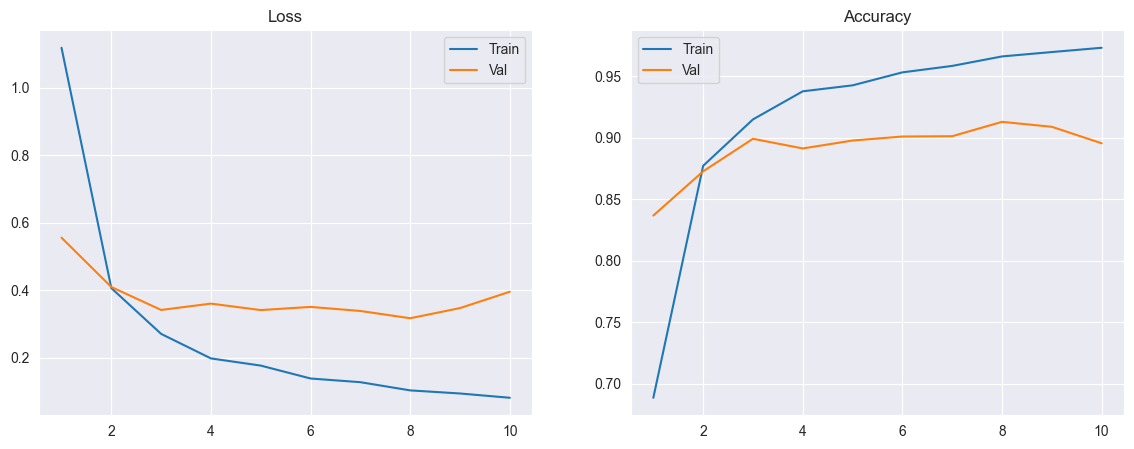

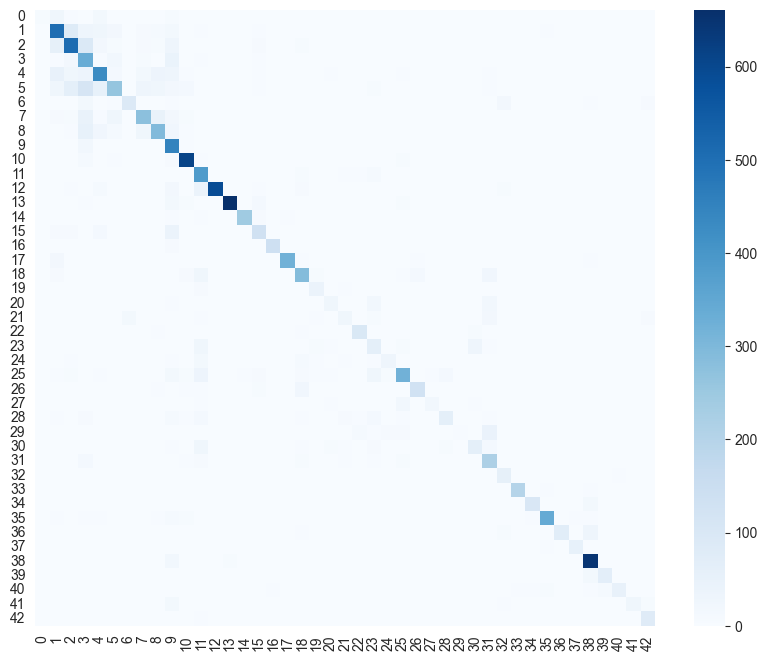

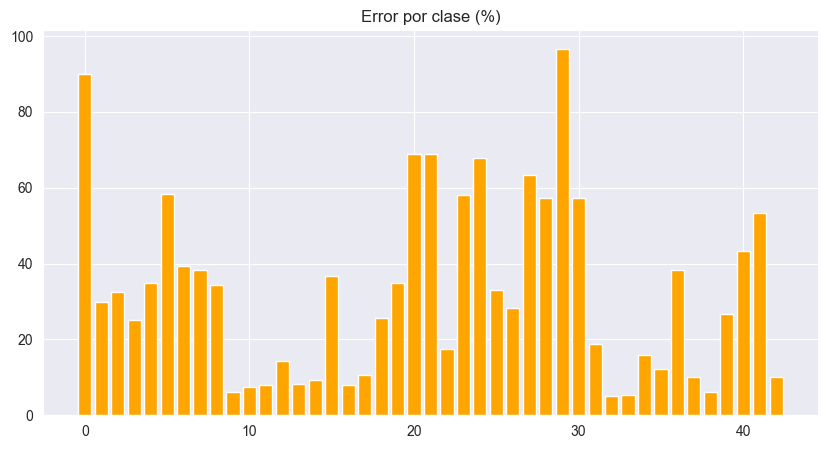

In [9]:
# Instancia el modelo
model_cnn = CNN(output_dim=43).to(device)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='cnn_shuffle'
train_loss_df, val_loss_df, test_loss, test_accuracy = train_and_evaluate(
    model_cnn, train_loader_shuffle, valid_loader_shuffle,
    loss_fn, optimizer, device, num_epochs, test_loader_shuffle, name='cnn_shuffle'
)




# Guarda el modelo. Usa file_name='cnn_shuffle.pth'


# Carga los datos y muéstralos
train_loss_file = 'train_loss_cnn_shuffle.csv'  
valid_loss_file = 'valid_loss_cnn_shuffle.csv'
train_accuracy_file = 'train_accuracy_cnn_shuffle.csv'
valid_accuracy_file = 'valid_accuracy_cnn_shuffle.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# Calcula la matriz de confusión
cm = plot_confusion_matrix(model_cnn, test_loader_shuffle, device=device)

# Muestra el porcentaje de error por clase
plot_error_per_class(cm)

¿Cómo podrías explicar los resultados?

############## COMPLETAR ##############

- MLP: La MLP ha obtenido un 89.28%, es un poco mejor que el del dataset original. Esto se puede deber a que la MLP gestiona las imágenes como vectores de pixeles independientes. Entonces da igual si un pixel esta en una posicion u otra, siempre que la permutación sea la misma para todos.

- CNN: El resultado de la CNN ha sido un 90.7% de accuracy, un poco peor que con el datset original. Las CNN se caracterizan por la buena capcidad que tienen para detectar bordes que forman formas y objetos. Al haber desordenado los píxeles hemos deshecho esa estructura por ello baja su rendimiento, aunque su resultado sigue siendo bueno porque como la permutacion es fija acaba aprendiendo correlaciones entre los píxeles desordenados.

############ Fin COMPLETAR ############

## **[Ejercicio 3]** Entrena una `FCNN` con las siguientes características:

1. Cuatro bloques convolucionales (conv2d -> batch norm -> ReLU).
2. Un bloque convolucional final con tantas características como clases haya (43)
3. Comprueba el número de parámetros entrenables y busca una configuración que no supere los **50.000** parámetros (aproximadamente 4 veces menos que la MLP).

In [7]:
class FCNN(nn.Module):
    def __init__(self, output_dim):
        super(FCNN, self).__init__()

        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(24)

        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Cuarto bloque convolucional
        self.conv4 = nn.Conv2d(32, 38, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(38)

        # Bloque de salida
        self.output_conv = nn.Conv2d(38, output_dim, kernel_size=4)

    def forward(self, x):
        # Primer bloque convolucional
        x = F.relu(self.bn1(self.conv1(x)))

        # Segundo bloque convolucional
        x = F.relu(self.bn2(self.conv2(x)))

        # Tercer bloque convolucional
        x = F.relu(self.bn3(self.conv3(x)))

        # Cuarto bloque convolucional
        x = F.relu(self.bn4(self.conv4(x)))

        # Capa de salida
        x = self.output_conv(x) # Salida (N, num_classes, 1, 1)
        x = x.view(x.size(0), -1)  # (N, num_classes)
        return x

count_trainable_params(FCNN(output_dim=43))

48261

Añade el modelo a tu archivo `models.py`.

### Entrena la FCNN con el dataset original (sin permutar)

* `train_loader`
* `valid_loader`
* `test_loader`

Guarda el modelo como `fcnn.pth` y los resultados de `loss`y `accuracy` con la misma extensión:

Epoch [1/10] - Train Loss: 0.8184, Val Acc: 0.9282
Epoch [2/10] - Train Loss: 0.1573, Val Acc: 0.9535
Epoch [3/10] - Train Loss: 0.0857, Val Acc: 0.9506
Epoch [4/10] - Train Loss: 0.0523, Val Acc: 0.9696
Epoch [5/10] - Train Loss: 0.0450, Val Acc: 0.9595
Epoch [6/10] - Train Loss: 0.0436, Val Acc: 0.9539
Epoch [7/10] - Train Loss: 0.0292, Val Acc: 0.9735
Epoch [8/10] - Train Loss: 0.0329, Val Acc: 0.9674
Epoch [9/10] - Train Loss: 0.0239, Val Acc: 0.9717
Epoch [10/10] - Train Loss: 0.0179, Val Acc: 0.9751


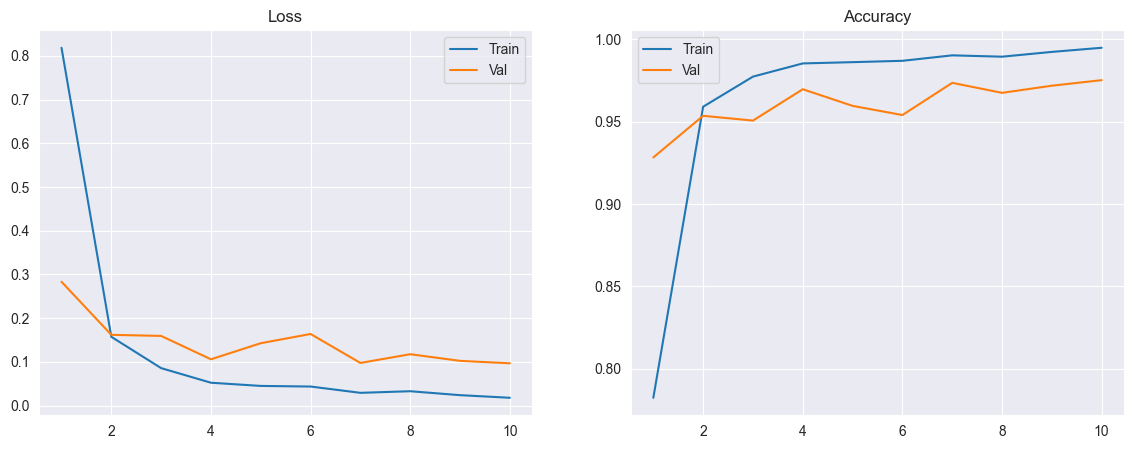

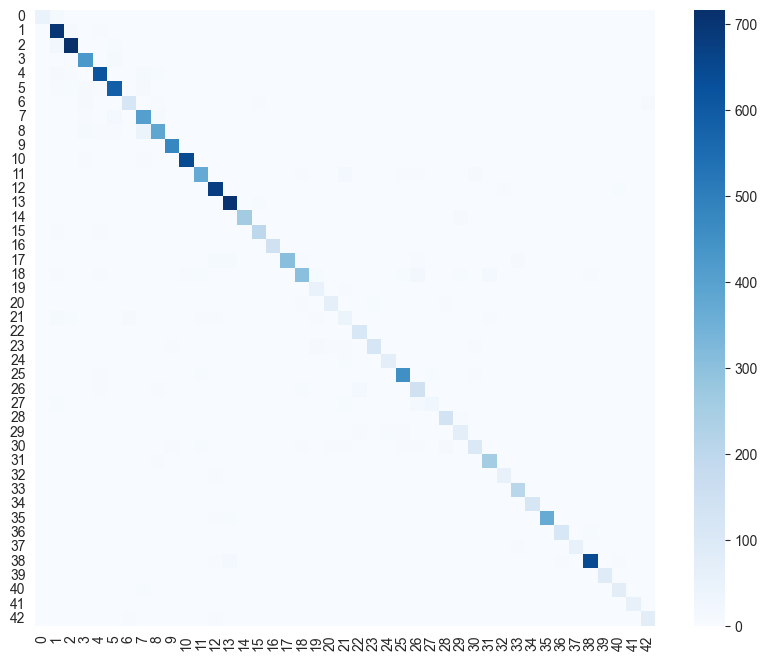

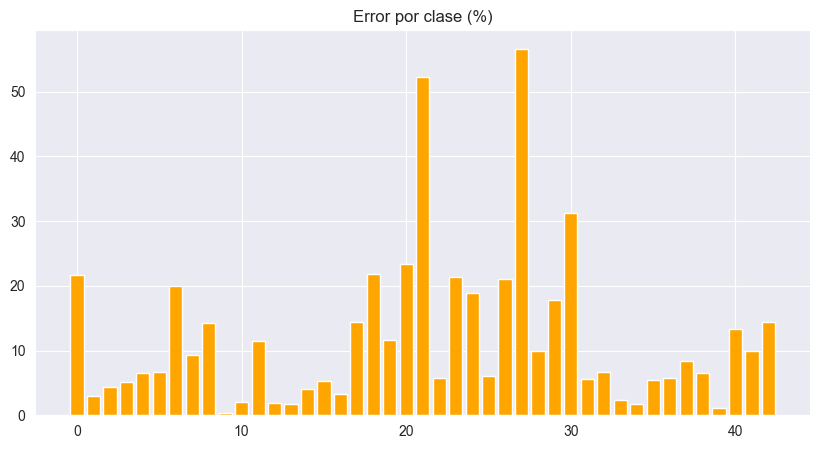

In [11]:
# Instancia el modelo
model_fcnn = FCNN(output_dim=43).to(device)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='fcnn'
train_loss_df, val_loss_df, test_loss, test_accuracy = train_and_evaluate(
    model_fcnn, train_loader, valid_loader,
    loss_fn, optimizer, device, num_epochs=10,
    test_loader=test_loader, name='fcnn'
)




# Guarda el modelo. Usa file_name='fcnn.pth'
save_full_model(model_fcnn, 'fcnn.pth')

# Carga los datos y muéstralos
train_loss_file = 'train_loss_fcnn.csv'  
valid_loss_file = 'valid_loss_fcnn.csv'
train_accuracy_file = 'train_accuracy_fcnn.csv'
valid_accuracy_file = 'valid_accuracy_fcnn.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# Calcula la matriz de confusión
cm = plot_confusion_matrix(model_fcnn, test_loader, device=device)

# Muestra el porcentaje de error por clase
plot_error_per_class(cm)

# **[Ejercicio 4]** Entrena una MLP y una FCNN con el dataset modificado

1. Crea un modelo con las características que quieras siempre y cuando no supere los **500.000** parámetros.
2. Entrena **30** épocas **SIN** aumentado de datos

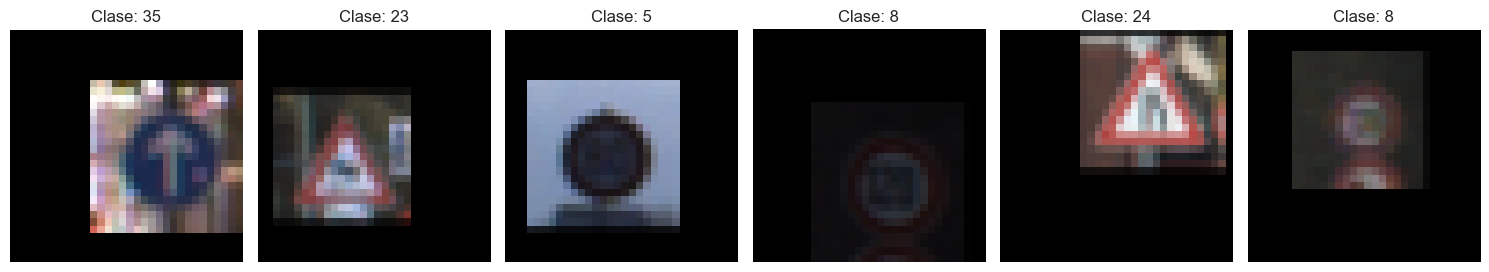

In [8]:
import random
from PIL import Image
import torchvision.transforms as T

import random
import hashlib
from PIL import Image

class DeterministicResizeAndPaste:
    def __init__(self, canvas_size, scale_range=(0.7, 0.9)):

        self.canvas_size = canvas_size if isinstance(canvas_size, tuple) else (canvas_size, canvas_size)
        self.scale_range = scale_range

    def _get_image_seed(self, img):

        img_bytes = img.tobytes()
        hash_object = hashlib.md5(img_bytes)
        return int(hash_object.hexdigest(), 16)

    def __call__(self, img):
        seed = self._get_image_seed(img)
        rng = random.Random(seed) 
        scale = rng.uniform(self.scale_range[0], self.scale_range[1])        

        orig_w, orig_h = img.size
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)        
        canvas = Image.new('RGB', self.canvas_size, (0, 0, 0))
        
        max_x = max(0, self.canvas_size[1] - new_w)
        max_y = max(0, self.canvas_size[0] - new_h)
        
        pos_x = rng.randint(0, max_x)
        pos_y = rng.randint(0, max_y)
        
        canvas.paste(img_resized, (pos_x, pos_y))        
        return canvas

# Definir las transformaciones 
transform = transforms.Compose([
    DeterministicResizeAndPaste(canvas_size=32),
    transforms.ToTensor()
])
train_dataset_ds2 = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset_ds2 = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset_ds2 = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

device = 'cpu'
batch_size = 16

train_loader_ds2 = DataLoader(train_dataset_ds2, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader_ds2 = DataLoader(valid_dataset_ds2, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_ds2 = DataLoader(test_dataset_ds2, batch_size=batch_size, shuffle=False, num_workers=0)


# Visualizar ejemplos del conjunto de entrenamiento
visualize_subset(train_dataset_ds2)

In [9]:
class FCNN_Large(nn.Module):
    def __init__(self, output_dim):
        super(FCNN_Large, self).__init__()
        # Bloque 1: 32x32 -> 32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Bloque 2: 32x32 -> 16x16 (stride 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Bloque 3: 16x16 -> 8x8 (stride 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Bloque 4: 8x8 -> 4x4 (stride 2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        # Salida: Colapsamos el mapa de 4x4 a 1x1
        self.output_conv = nn.Conv2d(128, output_dim, kernel_size=4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.output_conv(x)
        return x.view(x.size(0), -1)

count_trainable_params(FCNN_Large(output_dim=43))

329643

Epoch [1/30] - Train Loss: 2.8019, Val Acc: 0.3247
Epoch [2/30] - Train Loss: 1.8481, Val Acc: 0.4680
Epoch [3/30] - Train Loss: 1.3099, Val Acc: 0.5672
Epoch [4/30] - Train Loss: 0.9327, Val Acc: 0.6141
Epoch [5/30] - Train Loss: 0.6289, Val Acc: 0.7251
Epoch [6/30] - Train Loss: 0.4291, Val Acc: 0.7648
Epoch [7/30] - Train Loss: 0.2890, Val Acc: 0.8047
Epoch [8/30] - Train Loss: 0.2219, Val Acc: 0.8031
Epoch [9/30] - Train Loss: 0.1782, Val Acc: 0.8065
Epoch [10/30] - Train Loss: 0.1539, Val Acc: 0.8347
Epoch [11/30] - Train Loss: 0.1189, Val Acc: 0.7984
Epoch [12/30] - Train Loss: 0.1204, Val Acc: 0.8221
Epoch [13/30] - Train Loss: 0.0877, Val Acc: 0.8259
Epoch [14/30] - Train Loss: 0.0911, Val Acc: 0.8604
Epoch [15/30] - Train Loss: 0.0855, Val Acc: 0.7580
Epoch [16/30] - Train Loss: 0.0770, Val Acc: 0.8511
Epoch [17/30] - Train Loss: 0.0725, Val Acc: 0.8519
Epoch [18/30] - Train Loss: 0.0646, Val Acc: 0.8374
Epoch [19/30] - Train Loss: 0.0628, Val Acc: 0.8040
Epoch [20/30] - Train

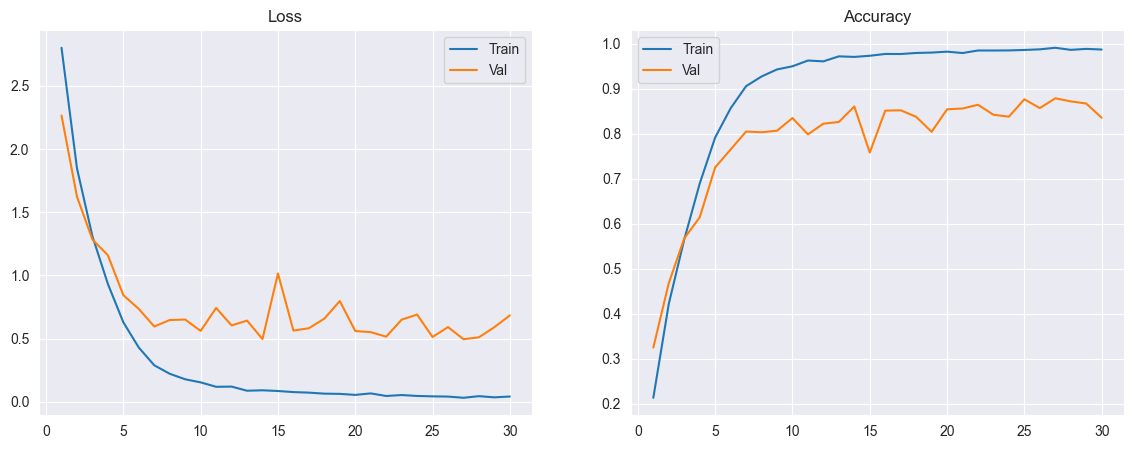

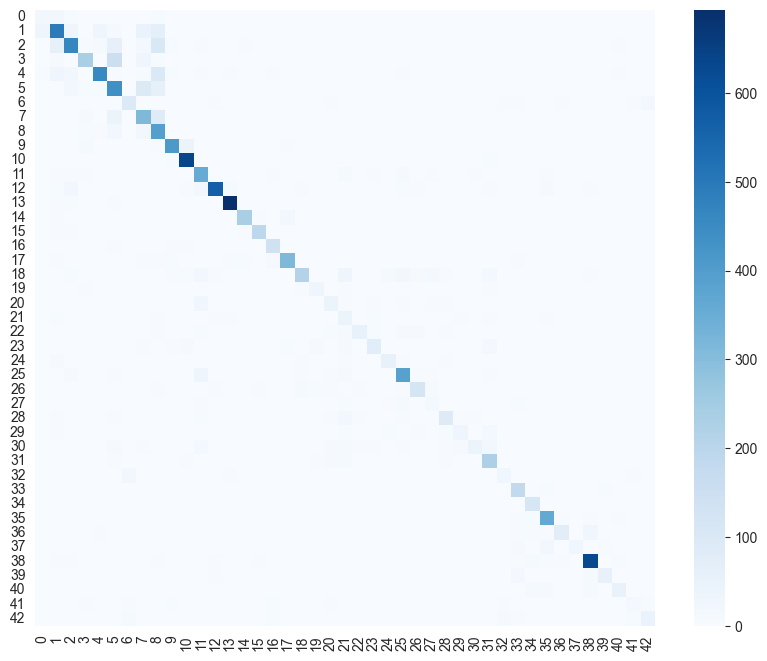

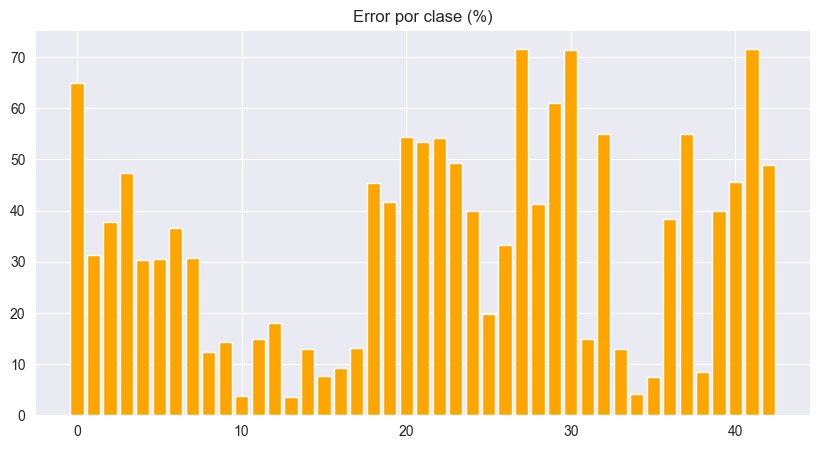

In [14]:
# Instancia del modelo potente
model_fcnn_ds2 = FCNN_Large(output_dim=43).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn_ds2.parameters(), lr=0.001)

# Entrenamos 30 épocas como pide el enunciado
num_epochs = 30

train_and_evaluate(
    model_fcnn_ds2,
    train_loader_ds2,
    valid_loader_ds2,
    loss_fn,

    optimizer,
    device,
    num_epochs=num_epochs,
    test_loader=test_loader_ds2,
    name='fcnn_ds2'
)

# Guardar y visualizar
save_full_model(model_fcnn_ds2, 'fcnn_ds2.pth')

plot_loss_accuracy('train_loss_fcnn_ds2.csv', 'valid_loss_fcnn_ds2.csv',
                   'train_accuracy_fcnn_ds2.csv', 'valid_accuracy_fcnn_ds2.csv')

cm_ds2 = plot_confusion_matrix(model_fcnn_ds2, test_loader_ds2, device=device)
plot_error_per_class(cm_ds2)

Epoch [1/30] - Train Loss: 3.3980, Val Acc: 0.1229
Epoch [2/30] - Train Loss: 3.1408, Val Acc: 0.1439
Epoch [3/30] - Train Loss: 3.0070, Val Acc: 0.1575
Epoch [4/30] - Train Loss: 2.9189, Val Acc: 0.1668
Epoch [5/30] - Train Loss: 2.8513, Val Acc: 0.1697
Epoch [6/30] - Train Loss: 2.7881, Val Acc: 0.1832
Epoch [7/30] - Train Loss: 2.7309, Val Acc: 0.1918
Epoch [8/30] - Train Loss: 2.6800, Val Acc: 0.2010
Epoch [9/30] - Train Loss: 2.6343, Val Acc: 0.1962
Epoch [10/30] - Train Loss: 2.5908, Val Acc: 0.2116
Epoch [11/30] - Train Loss: 2.5556, Val Acc: 0.2118
Epoch [12/30] - Train Loss: 2.5173, Val Acc: 0.2097
Epoch [13/30] - Train Loss: 2.4818, Val Acc: 0.2133
Epoch [14/30] - Train Loss: 2.4570, Val Acc: 0.2138
Epoch [15/30] - Train Loss: 2.4272, Val Acc: 0.2248
Epoch [16/30] - Train Loss: 2.3983, Val Acc: 0.2193
Epoch [17/30] - Train Loss: 2.3775, Val Acc: 0.2215
Epoch [18/30] - Train Loss: 2.3561, Val Acc: 0.2164
Epoch [19/30] - Train Loss: 2.3300, Val Acc: 0.2220
Epoch [20/30] - Train

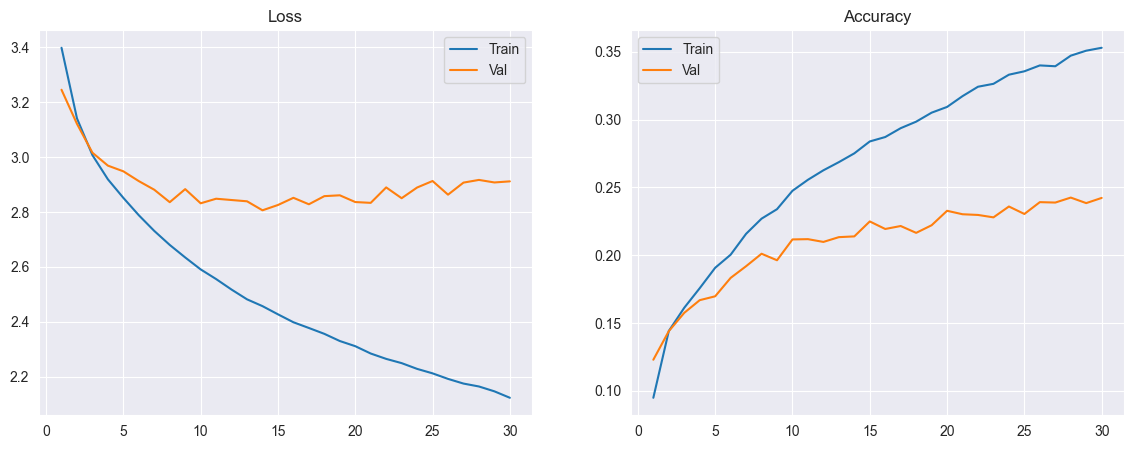

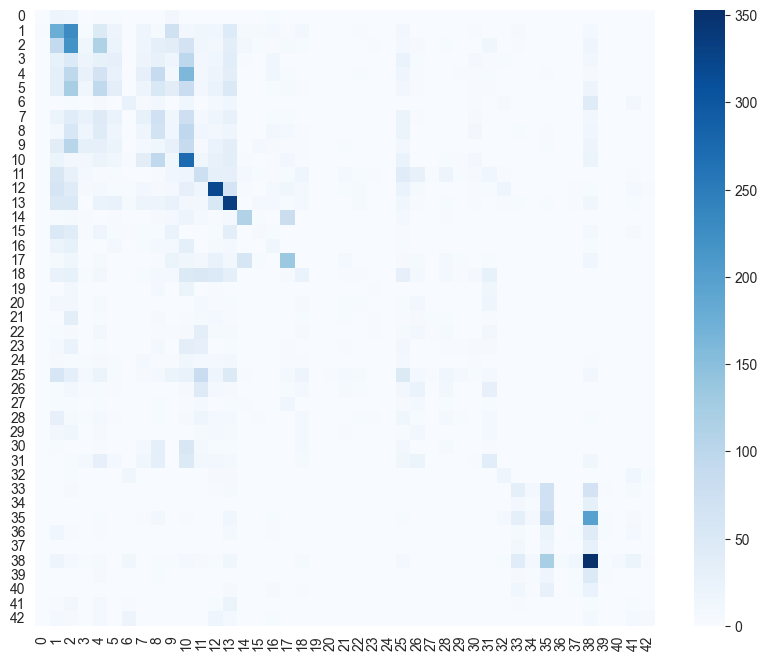

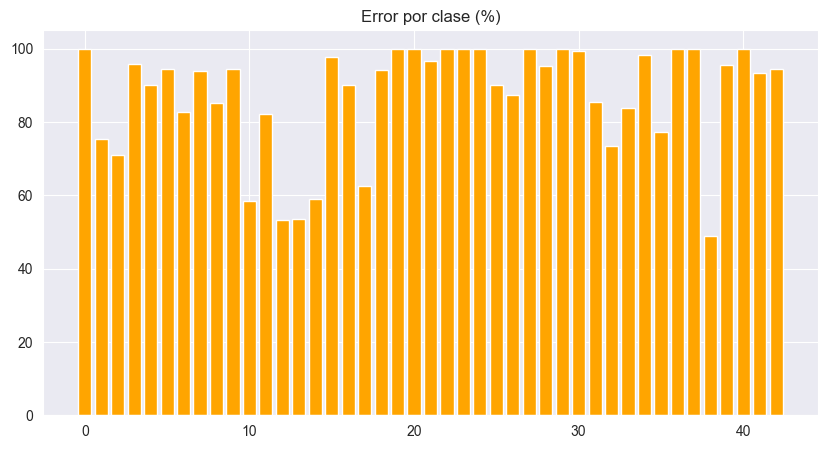

In [11]:
from models import MLP

# Entrada: 32x32x3 = 3072 píxeles
# Oculta: 150 neuronas -> (3072 * 150) + (150 * 43) = ~467k parámetros
model_mlp_ds2 = MLP(input_size=32*32*3, hidden_size=150, output_size=43).to(device)

count_trainable_params(model_mlp_ds2)

optimizer = torch.optim.Adam(model_mlp_ds2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Entrenamos 30 épocas SIN aumentado de datos
train_and_evaluate(
    model_mlp_ds2, train_loader_ds2, valid_loader_ds2,
    loss_fn, optimizer, device, num_epochs=30,
    test_loader=test_loader_ds2, name='mlp_ds2'
)

save_full_model(model_mlp_ds2, 'mlp_ds2.pth')

plot_loss_accuracy(
    'train_loss_mlp_ds2.csv', 'valid_loss_mlp_ds2.csv',
    'train_accuracy_mlp_ds2.csv', 'valid_accuracy_mlp_ds2.csv'
)

# Calcula y muestra la matriz de confusión
cm_mlp_ds2 = plot_confusion_matrix(model_mlp_ds2, test_loader_ds2, device=device)

# Muestra el porcentaje de error por clase
plot_error_per_class(cm_mlp_ds2)

La MLP fracasa porque es incapaz de reconocer una señal si cambia de posición, al carecer de invarianza espacial. La FCNN rinde mejor, pero sufre porque el dataset ds2 le exige localizar y clasificar simultáneamente en un espacio mayor. Esto lo podríamos solucionar con un aumentado de datospara enseñar al modelo a ser indiferente a la posición de la señal